In [1]:
# from maap.maap import MAAP
# maap = MAAP(maap_host='api.maap-project.org')

In [2]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys
from datetime import datetime, timedelta
from itertools import chain

from datetime import date


sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [3]:
#cwfis_perims = gpd.read_file("/projects/old_shared/fire_weather_vis/Lightning_analysis/CWFIS/perim_progression/progression.shp")

In [4]:
#cwfis_perims = cwfis_perims.set_crs("EPSG:4326")


In [5]:
#cwfis_perims[1:4].explore()

In [6]:
#cwfis_perims.columns

In [7]:
import seaborn as sn

In [8]:
#cwfis_perims.DATE

In [9]:
# cwfis_perims["log_area"] = np.log(cwfis_perims.AREA)
# cwfis_perims["better_format_date"] = pd.to_datetime(cwfis_perims.DATE.astype("str"), format="%Y%m%d.0")
# #cwfis_perims.DATE = cwfis_perims.DATE.astype("datetime64[ns]")
# cwfis_perims["better_format_date2"] = cwfis_perims["better_format_date"].astype("datetime64[ns]").dt.strftime("%m-%d")

# heat = cwfis_perims[["CONSIS_ID", "log_area", "better_format_date2"]].pivot(index="CONSIS_ID", columns="better_format_date2", values="log_area")
# ax = sn.heatmap(heat, cmap = "YlOrBr")
# ax.set(xlabel="", ylabel="")

In [10]:
### Sort by lattitude 

# cwfis_perims["x_component"] = cwfis_perims.geometry.centroid.x
# cwfis_perims["y_component"] = cwfis_perims.geometry.centroid.y

# cwfis_perims = cwfis_perims.sort_values(by = "y_component")



# cwfis_perims["log_area"] = np.log(cwfis_perims.AREA)
# cwfis_perims["better_format_date"] = pd.to_datetime(cwfis_perims.DATE.astype("str"), format="%Y%m%d.0")
# #cwfis_perims.DATE = cwfis_perims.DATE.astype("datetime64[ns]")
# cwfis_perims["better_format_date2"] = cwfis_perims["better_format_date"].astype("datetime64[ns]").dt.strftime("%m-%d")

# heat = cwfis_perims[["CONSIS_ID", "log_area", "better_format_date2", "y_component"]].pivot(index="CONSIS_ID", columns="better_format_date2", values="log_area")
# ax = sn.heatmap(heat, cmap = "YlOrBr")
# ax.set(xlabel="", ylabel="")

In [11]:
#cwfis_perims[["CONSIS_ID", "log_area", "better_format_date2", "y_component"]]

In [12]:
#heat.sort_values()

In [13]:
### Now with feds perimeters

#path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/20_days_fire_stats_only_718270-99999_minT20230301_maxT20230830_BOREAL_NRT_3571_DPSstation20231120.csv" ## looking for lightning 20 days before start

#path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_only/April_1_unmerged_fires_with_FWI.csv" ### The weirder fires. 

path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/Quebec_all_fires_merged_together_06172024.csv" # Fires with "fixed' lf bug. 
fires = fv.prep_fire_files(path)

fires = fires.to_crs(4326)
#fires = fv.remerge_largefire(fires) ### CAUSES ISSUES WITH AREA DIFFERENCING. 

In [14]:
fires.columns

Index(['fireID', 't', 'geometry', 'Unnamed: 0.2', 'csv_geometry',
       'Unnamed: 0.1', 'csv_geometry', 'Unnamed: 0', 'InterCloud', 'lat',
       'lon', 'current_mag', 'error_elps', 'num_station', 'num_candidates',
       'num_strikes', 'num_strikes_10_days', 'no_strikes_in_time',
       'viirs_pix_count', 'n_pixels', 'n_newpixels', 'farea', 'fperim',
       'flinelen', 'duration', 'pixden', 'meanFRP', 'csv_geometry.1',
       'lon_centroid', 'lat_centroid', 'GEOS-5.IMERGEARLY', 'FWI',
       'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4', 'FWI_lead_5',
       'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8', 'pre_fire', 'composit_ids',
       'rows_edited'],
      dtype='object')

In [15]:
len(fires.fireID.unique())

134

In [16]:
fires = fires[~fires.geometry.isna()]

In [17]:
fires = fires.sort_values(by = ["fireID", "t"])
fires.farea = fires.farea.astype("int64")
#fires["farea_diff"] = fires.groupby("fireID").farea.diff()

In [18]:
# fires.loc[(fires.farea_diff < 0), ['fireID', 't', 'geometry',  'farea', 'pre_fire', 'composit_ids',
#        'rows_edited', "farea_diff"]]

# fires.loc[(fires.fireID == "10140"), ['fireID', 't', 'geometry',  'farea', 'pre_fire', 'composit_ids',
#        'rows_edited', "farea_diff"]].composit_ids.unique()

In [19]:
#fires[fires.fireID == '12596']

In [20]:
# weird_diff_ids = fires[fires.farea_diff< 0][["fireID", "t", "farea", "farea_diff"]].fireID.unique()

# fires[fires.fireID.isin(weird_diff_ids)][["fireID", "t", "farea", "farea_diff"]]
fires.columns


Index(['fireID', 't', 'geometry', 'Unnamed: 0.2', 'csv_geometry',
       'Unnamed: 0.1', 'csv_geometry', 'Unnamed: 0', 'InterCloud', 'lat',
       'lon', 'current_mag', 'error_elps', 'num_station', 'num_candidates',
       'num_strikes', 'num_strikes_10_days', 'no_strikes_in_time',
       'viirs_pix_count', 'n_pixels', 'n_newpixels', 'farea', 'fperim',
       'flinelen', 'duration', 'pixden', 'meanFRP', 'csv_geometry.1',
       'lon_centroid', 'lat_centroid', 'GEOS-5.IMERGEARLY', 'FWI',
       'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4', 'FWI_lead_5',
       'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8', 'pre_fire', 'composit_ids',
       'rows_edited'],
      dtype='object')

In [21]:
fires.t.max()

'2023-09-26 00:00:00'

In [71]:
def get_centroid(df):
    df_tmp = df[~df.geometry.isnull()]
    max_t = df_tmp.t.max()
    lat = df_tmp[df_tmp.t == max_t].centroid.y
    lon = df_tmp[df_tmp.t == max_t].centroid.x
    #print(lat.iloc[0])
    df["lat_centroid"] = lat.iloc[0]
    df["lon_centroid"] = lon.iloc[0]
    return(df)

def chop_fires_at_end(df):
    final_t = df[df.n_newpixels > 0].t.max()
    df = df[df.t <= final_t]
    return(df)

def diff_fix(df, col = "farea"):
    
    df[col+ "_diff"] = df.groupby("fireID")[col].diff()
    if(len(df.loc[df[col+ "_diff"].isna(), [col+ "_diff"]]) == 1):
        df.loc[df[col+ "_diff"].isna(), [col+ "_diff"]] = df.loc[df[col+ "_diff"].isna(), [col]] ## Setting the first value column that the differenceing is happening in. In fire area, represents the ingition area
    else:
        print(f"ERROR: More that one nan value in diff! Does not represent first value of {col}!" )
    return(df)
    

In [23]:
#fires = fires.groupby("fireID").apply(get_centroid).reset_index()


fires.t = pd.to_datetime(fires.t, format='ISO8601')

#fires.better_format_date.astype("datetime64[ns]")
fires["pretty_date_format"] = fires.t.astype("datetime64[ns]").dt.strftime("%m-%d %p")
fires = fires[fires.pretty_date_format.str.contains("PM")] ## Make  only night to night comparisons
fires["pretty_date_format"] = fires.t.astype("datetime64[ns]").dt.strftime("%m-%d")

fires["farea_diff"] = fires.groupby("fireID").farea.diff()

fires = fires.groupby("fireID").apply(chop_fires_at_end).reset_index(drop=True)


fires = fires.groupby("fireID").apply(get_centroid).reset_index(drop=True)

/tmp/ipykernel_2561/4035619963.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = df_tmp[df_tmp.t == max_t].centroid.y
/tmp/ipykernel_2561/4035619963.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = df_tmp[df_tmp.t == max_t].centroid.x
/tmp/ipykernel_2561/4035619963.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = df_tmp[df_tmp.t == max_t].centroid.y
/tmp/ipykernel_2561/4035619963.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS b

In [24]:
#fires["log_area"] = np.log(fires.farea)


#fires["better_format_date"] = pd.to_datetime(fires.t.astype("str"), format="%Y%m%d.0")
#cwfis_perims.DATE = cwfis_perims.DATE.astype("datetime64[ns]")
#cwfis_perims["better_format_date2"] = cwfis_perims["better_format_date"].astype("datetime64[ns]").dt.strftime("%m-%d")
no_dupes = fires[["fireID", "pretty_date_format", "farea_diff", "lat_centroid", "t"]]
#no_dupes[no_dupes.fireID == '9203']

In [25]:
#no_dupes[no_dupes.farea_diff < 0]

In [26]:
# heat = no_dupes.reset_index().pivot_table(index =no_dupes.index ,  columns=["fireID","t"], values="log_area")
# ax = sn.heatmap(heat, cmap = "YlOrBr")
# ax.set(xlabel="", ylabel="")

In [27]:
# no_dupes.t = no_dupes.t.astype('datetime64[ns]')
# no_dupes.fireID = no_dupes.fireID.astype("int64")

no_dupes = no_dupes.dropna()
no_dupes = no_dupes.drop_duplicates(subset = ["fireID", "t"])
no_dupes["log_difference"] = np.log(no_dupes.farea_diff)

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
no_dupes.columns

Index(['fireID', 'pretty_date_format', 'farea_diff', 'lat_centroid', 't',
       'log_difference'],
      dtype='object')

In [29]:
# Get the mean centroid point per fireID

lats = no_dupes[['fireID', 'pretty_date_format', 'farea_diff', 'lat_centroid', 't',
       'log_difference']].groupby("fireID").lat_centroid.mean().reset_index()
lats

,fireID,lat_centroid
0,10013,52.516399
1,10056,51.141514
2,10140,49.351853
3,10286,54.224434
4,10435,49.048535
...,...,...
124,9188,50.617260
125,9266,50.388105
126,9275,49.756406
127,9791,50.796113


In [30]:
#no_dupes

In [31]:
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

#no_dupes = no_dupes[['fireID', 'pretty_date_format', 'farea_diff', 'log_difference', 't']].merge(lats, on = ["fireID"])
no_dupes = no_dupes[['fireID','pretty_date_format', 'farea_diff', 'log_difference', 't']].reset_index().merge(lats, on = ["fireID"])

In [32]:
#no_dupes.farea_diff = no_dupes.farea_diff

In [33]:

no_dupes["farea_diff_mod"] = no_dupes.farea_diff + 1 # Account for log. Minimum = 1. 
no_dupes.loc[(no_dupes.farea_diff_mod < 0), ["farea_diff_mod"]] = 1

print(no_dupes.columns)

#heat = no_dupes.pivot(index =["fireID", "lat_centroid"],  columns=["pretty_date_format"], values="farea_diff")
#heat = no_dupes.pivot(index =["lat_centroid"],  columns=['pretty_date_format'], values="farea_diff")
heat = no_dupes.pivot(index =["lat_centroid"],  columns=['pretty_date_format'], values="farea_diff_mod")

Index(['index', 'fireID', 'pretty_date_format', 'farea_diff', 'log_difference',
       't', 'lat_centroid', 'farea_diff_mod'],
      dtype='object')


In [34]:
heat = heat.sort_values(by = "lat_centroid", ascending= False)
heat.index = heat.index.astype("float64")

heat.index = heat.index.values.round(2)



In [35]:
#cwfis_perims[["CONSIS_ID", "log_area", "better_format_date2", "y_component"]][cwfis_perims.CONSIS_ID == 56414]

In [36]:
#no_dupes = no_dupes.set_index(['fireID', 'pretty_date_format', 'farea_diff'], append=True)

In [37]:
# heat = no_dupes[2485:2500].pivot(index = "fireID", columns=["pretty_date_format"], values="farea_diff")
# ax = sn.heatmap(heat, cmap = "YlOrBr")
# ax.set(xlabel="", ylabel="")

In [38]:
#s3.ls("s3://veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/")

In [39]:
#s3.ls("s3://veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing")



In [40]:
# no_dupes[no_dupes.farea_diff <0 ]

In [41]:
FWI_data_south = pd.read_csv("https://portal.nccs.nasa.gov/datashare/GlobalFWI/ForecastFWIEXPERIMENTAL/QuebecEcoSuppressionRegions/GEOS-5/GEOS-5.IMERGEARLY/90_P/chicletDataNoSmoothing/001.SouthernEcoregions_FullResponseZone.FWI.raw.chiclet.csv")

FWI_data_north = pd.read_csv("https://portal.nccs.nasa.gov/datashare/GlobalFWI/ForecastFWIEXPERIMENTAL/QuebecEcoSuppressionRegions/GEOS-5/GEOS-5.IMERGEARLY/90_P/chicletDataNoSmoothing/002.NorthernEcoregions_LimitedResponseZone.FWI.raw.chiclet.csv")

In [42]:
fwis = FWI_data_south[["INITDATE", "0"]]
fwis = fwis.rename(columns={"0":"GEOS_5"})

fwin = FWI_data_north[["INITDATE", "0"]]
fwin = fwin.rename(columns={"0":"GEOS_5"})

In [43]:
# plt.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
# plt.ylabel("FWI")

In [44]:
# fig, (ax, ax2) = plt.subplots(2)
# ax.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
# ax.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
# ax.set_ylabel("FWI")

In [45]:
no_dupes.columns

Index(['index', 'fireID', 'pretty_date_format', 'farea_diff', 'log_difference',
       't', 'lat_centroid', 'farea_diff_mod'],
      dtype='object')

Text(55.847222222222214, 0.5, 'FWI')

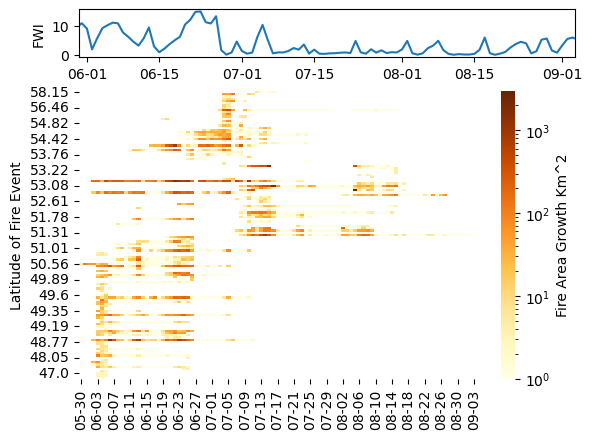

In [46]:
import matplotlib.dates as mdates

fig, (ax, ax2) = plt.subplots(2, gridspec_kw={'height_ratios': [1, 6]})
#fig.suptitle('Aligning x-axis using sharex')
ax2 = sn.heatmap(heat, cmap = "YlOrBr", norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, fmt='.1f')#, 
               #yticklabels=heat.index.values.round(0))
ax2.set(xlabel="", ylabel="Latitude of Fire Event")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
ax.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
ax.set_ylabel("FWI")
#plt.savefig('Regional_fire_growth_FWI.png')

In [47]:
# dates = heat.columns.values.astype('datetime64[ns]')
# dates.values.astype('datetime64[ns]')

dates = no_dupes['t'].astype('datetime64[ns]')
dates = dates.drop_duplicates()
print(len(dates.dt.strftime('%-m-%-d')))
print(len(heat.columns))

97
97


In [48]:
### New Color bar

from matplotlib.colors import LinearSegmentedColormap

# Retrieve the original colormap
original_cmap = plt.get_cmap('YlOrBr')



def create_darker_colormap(base_cmap_name, darkness_factor):
    """
    Create a darker version of a given colormap.
    
    Parameters:
    - base_cmap_name: str, the name of the base colormap.
    - darkness_factor: float, a factor between 0 and 1 to darken the colormap.
                       1 means no change, 0 means completely dark.
    
    Returns:
    - LinearSegmentedColormap: a new colormap that is a darker version of the base colormap.
    """
    # Retrieve the original colormap
    base_cmap = plt.get_cmap(base_cmap_name)
    
    # Create a list of colors from the colormap and darken them
    colors = base_cmap(np.linspace(0, 1, 256))
    colors[:, :3] *= darkness_factor
    colors = np.clip(colors, 0, 1)  # Ensure values are within [0, 1]
    
    # Create the new colormap
    return LinearSegmentedColormap.from_list(f"{base_cmap_name}_darker", colors)

# Define the darkness factor (between 0 and 1)
darkness_factor = 0.85

# Create a custom colormap with the specified darkness factor
darker_cmap = create_darker_colormap('YlOrBr', darkness_factor)

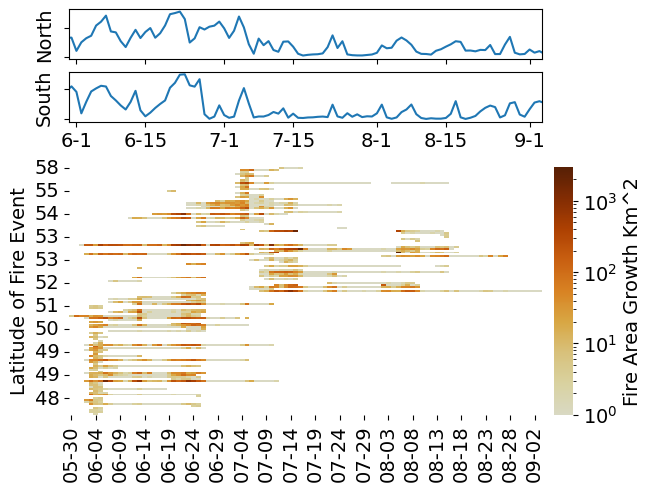

In [49]:
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.ticker import StrMethodFormatter
#from matplotlib.ticker import IndexFormatter
# fig, ax  = plt.subplots(2, 2, sharex='col', gridspec_kw={'width_ratios':[100,5]})
# ax[0,1].remove()  # remove unused upper right axes
# ax[0,0].plot(x+0.5,L_1,'-', marker='o',color='tab:orange')
# sn.heatmap(M_1, cmap=cmap, vmax=np.max(M_1), center=np.max(M_1)/2., square=False, ax=ax[1,0], cbar_ax=ax[1,1])

def quick_round(x, pos=None):
    x = float(x)
    r = round(x, 0)
    return(r)

def quick_round2(x, pos = None, obj = heat):
    x = int(x)
    x = obj.index[x]
    #x = float(x)
    r = round(x, 0)
    r = int(r)
    return(r)

#plt.style.use('dark_background')
with mpl.rc_context({'font.size': 14}):
    fig, ([ax, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3,2, gridspec_kw={'width_ratios':[100,4], 'height_ratios': [1,1, 5]}, constrained_layout=True)
    #fig.suptitle('Aligning x-axis using sharex')

    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    ax.plot(fwin.INITDATE.astype("datetime64[ns]"),fwin.GEOS_5)
    ax.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
    ax.set_ylabel("North")
    ax.set_xticklabels("")
    ax.set_yticklabels("")


    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%-d'))
    ax3.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
    ax3.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
    ax3.set_ylabel("South")
    ax3.set_yticklabels("")



    #ax3 = 
    #sn.heatmap(heat, cmap = "YlOrBr", norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, ax = ax5, cbar_ax=ax6, square=False)#,fmt='.1f', 
    sn.heatmap(heat, cmap = darker_cmap, norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, ax = ax5, cbar_ax=ax6, square=False)#,fmt='.1f', 
    ax5.set(xlabel="", ylabel="Latitude of Fire Event")
    ax5.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(quick_round2))

    #ax5.yaxis.set_major_formatter(StrMethodFormatter('{x:,f}'))
    #ax5.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(quick_round))
    #ax5.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    #fmtr = mpl.ticker.FuncFormatter(heat.index.round(0))
   
    ax2.remove()
    ax4.remove()

    #plt.gcf().subplots_adjust(bottom=0.15)
    #plt.tight_layout()
    #plt.show()
    #plt.savefig('darker_Regional_fire_growth_FWI.png', dpi = 900, transparent = True)
    #plt.savefig('low_rez_darker_Regional_fire_growth_FWI.png', dpi = 100, transparent = False)
    plt.savefig('/projects/old_shared/fire_weather_vis/Lightning_analysis/some_figs/darker_Regional_fire_growth_FWI.png', dpi = 900, transparent = False)

In [50]:
heat.index[4]

56.88

In [51]:
example = no_dupes[(no_dupes.lat_centroid <= 58.00) & (no_dupes.lat_centroid >= 54.86)].pivot(index =["lat_centroid"],  columns=['pretty_date_format'], values="farea_diff")

In [52]:
def make_heat_map(path, piv_values):
    '''
    path (str): 
    piv_values (str):
    
    '''
    ## Read in 
    fires = fv.prep_fire_files(path)
    fires = fires.to_crs(4326)
    fires = fires[~fires.geometry.isna()]
    fires = fires.sort_values(by = ["fireID", "t"])
    fires.farea = fires.farea.astype("int64")
    fires.t = pd.to_datetime(fires.t, format='ISO8601')

    ## Make the dataes into a nicer format
    fires["pretty_date_format"] = fires.t.astype("datetime64[ns]").dt.strftime("%m-%d %p")
    fires = fires[fires.pretty_date_format.str.contains("PM")] ## Make  only night to night comparisons
    fires["pretty_date_format"] = fires.t.astype("datetime64[ns]").dt.strftime("%m-%d")


    ### Cacluate number for plot
    fires["farea_diff"] = fires.groupby("fireID").farea.diff()

    fires = fires.groupby("fireID").apply(chop_fires_at_end).reset_index(drop=True) ## Find where fires "end"

    fires = fires.groupby("fireID").apply(get_centroid).reset_index(drop=True) ## get lat centroids for later use


    ### Make a new datarame with no duplicates
    no_dupes = fires[["fireID", "pretty_date_format", "farea_diff", "lat_centroid", "t", "FWI"]]
    no_dupes = no_dupes.dropna()
    no_dupes = no_dupes.drop_duplicates(subset = ["fireID", "t"])
    no_dupes["log_difference"] = np.log(no_dupes.farea_diff)


    ### Find mean lat so that the lattitide axis is prettier
    lats = no_dupes[['fireID', 'pretty_date_format', 'farea_diff', 'lat_centroid', 't',
           'log_difference', "FWI"]].groupby("fireID").lat_centroid.mean().reset_index()
    no_dupes = no_dupes[['fireID','pretty_date_format', 'farea_diff', 'log_difference', 't', "FWI"]].reset_index().merge(lats, on = ["fireID"])

    ## Change values so they don't get set as NA on a log scale

    no_dupes["farea_diff_mod"] = no_dupes.farea_diff + 1 # Account for log. Minimum = 1. 
    no_dupes.loc[(no_dupes.farea_diff_mod < 0), ["farea_diff_mod"]] = 1

    print("modifying values to fit log color scale: 0 -> 1, nagative number -> 1")


    ### Put into pivot table
    heat = no_dupes.pivot(index =["lat_centroid"],  columns=['pretty_date_format'], values= piv_values)

    heat = heat.sort_values(by = "lat_centroid", ascending= False)
    heat.index = heat.index.astype("float64")

    heat.index = heat.index.values.round(2)

    return([heat, no_dupes])
    

In [53]:
test_func = make_heat_map("/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/Quebec_all_fires_merged_together_06172024.csv", "farea_diff_mod")

/tmp/ipykernel_2561/4035619963.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = df_tmp[df_tmp.t == max_t].centroid.y
/tmp/ipykernel_2561/4035619963.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = df_tmp[df_tmp.t == max_t].centroid.x
/tmp/ipykernel_2561/4035619963.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = df_tmp[df_tmp.t == max_t].centroid.y
/tmp/ipykernel_2561/4035619963.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS b

modifying values to fit log color scale: 0 -> 1, nagative number -> 1


/tmp/ipykernel_2561/4035619963.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = df_tmp[df_tmp.t == max_t].centroid.x
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [54]:
import shapely

zones = gpd.read_file("/projects/old_shared/fire_weather_vis/Lightning_analysis/supression_zones_quebec/Full_response_limit.shp")
zones= zones.set_crs(32198)

zones = zones.to_crs("4326")


# def get_mid_line(bounds):
#     mid_x = (bounds[0] + bounds[2])/2
#     mid_y = (bounds[1] + bounds[3])/2
#     mid_line = shapely.LineString([[bounds[0], mid_y], [mid_x, mid_y], [bounds[2], mid_y]])
#     return(mid_line)


# zones_avg_line = zones.copy()
# zones_avg_line['geometry'] = get_mid_line(zones.geometry[0].bounds)

In [55]:
test_func[0].columns[-1]

'09-03'

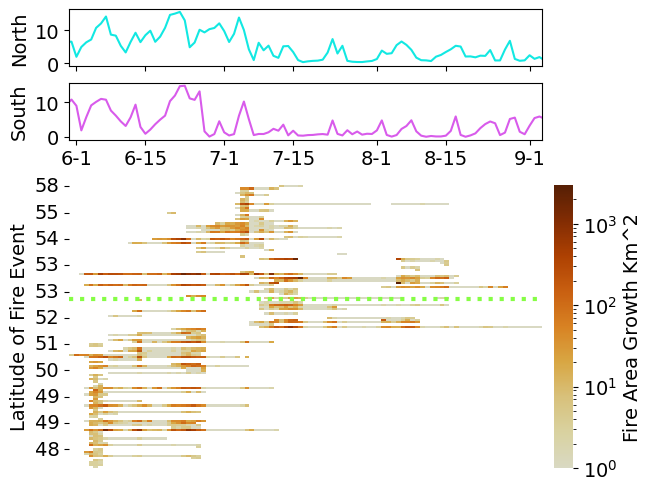

In [66]:
with mpl.rc_context({'font.size': 14}):
    fig1, ([ax, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3,2, gridspec_kw={'width_ratios':[100,4], 'height_ratios': [1,1, 5]}, constrained_layout=True)
    #fig.suptitle('Aligning x-axis using sharex')

    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    ax.plot(fwin.INITDATE.astype("datetime64[ns]"),fwin.GEOS_5, color = "#12e8e2")
    ax.set_xlim(test_func[1].t.astype("datetime64[ns]").min(), test_func[1].t.astype("datetime64[ns]").max())
    ax.set_ylabel("North")
    ax.set_xticklabels("")
    #ax.set_yticklabels("")


    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%-d'))
    ax3.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5, color = "#d85beb")
    ax3.set_xlim(test_func[1].t.astype("datetime64[ns]").min(), test_func[1].t.astype("datetime64[ns]").max())
    ax3.set_ylabel("South")
    #ax3.set_yticklabels("")



    #ax3 = 
    #sn.heatmap(heat, cmap = "YlOrBr", norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, ax = ax5, cbar_ax=ax6, square=False)#,fmt='.1f', 
    sn.heatmap(test_func[0], cmap = darker_cmap, norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, ax = ax5, cbar_ax=ax6, square=False)#,fmt='.1f', 
    
    ax5.axhline(y = (zones.geometry[0].bounds[1]+ zones.geometry[0].bounds[3])/2, color = "#86fd45", linestyle = "dotted", linewidth=3)
    #ax5.axhline(y = (zones.geometry[0].bounds[1]+ zones.geometry[0].bounds[3])/2, color = "#777777", linestyle = "dotted")
    #print((zones.geometry[0].bounds[1] + zones.geometry[0].bounds[3])/2)
    ax5.axes.get_xaxis().set_visible(False)
    ax5.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(quick_round2))
    
    #zones_avg_line.plot(ax= ax5, color = "#86fd45", linestyles='dotted', linewidths = 2)
    
    ax5.set(xlabel="", ylabel="Latitude of Fire Event")
    
    #ax5.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax2.remove()
    ax4.remove()
    
    plt.savefig('some_figs/low_rez_darker_Regional_fire_growth_FWI_with_line.png', dpi = 900, transparent = False)

In [57]:
fwis.INITDATE.astype("datetime64[ns]").min()

Timestamp('2023-01-01 00:00:00')

In [58]:
get_fwi = make_heat_map("/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/Quebec_all_fires_merged_together_06172024.csv", "FWI")

/tmp/ipykernel_2561/4035619963.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = df_tmp[df_tmp.t == max_t].centroid.y
/tmp/ipykernel_2561/4035619963.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = df_tmp[df_tmp.t == max_t].centroid.x
/tmp/ipykernel_2561/4035619963.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = df_tmp[df_tmp.t == max_t].centroid.y
/tmp/ipykernel_2561/4035619963.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS b

modifying values to fit log color scale: 0 -> 1, nagative number -> 1


/tmp/ipykernel_2561/4035619963.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = df_tmp[df_tmp.t == max_t].centroid.y
/tmp/ipykernel_2561/4035619963.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = df_tmp[df_tmp.t == max_t].centroid.x
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


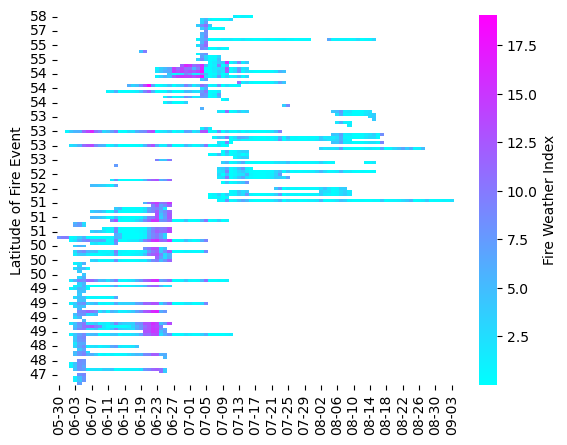

In [59]:
fig2, (ax2) = plt.subplots(1)
#fig.suptitle('Aligning x-axis using sharex')
ax2 = sn.heatmap(get_fwi[0], cmap = "cool", cbar_kws={'label': 'Fire Weather Index'}, fmt='.1f')#, 
               #yticklabels=heat.index.values.round(0))
ax2.set(xlabel="", ylabel="Latitude of Fire Event")
ax2.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(quick_round2))


#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
#ax.set_xlim(get_fwi[1].t.astype("datetime64[ns]").min(), get_fwi[1].t.astype("datetime64[ns]").max())
#ax.set_ylabel("FWI")

#plt.savefig('FWI_for_darker_Regional_fire_growth_FWI.png', dpi = 900, transparent = True)

plt.savefig('/projects/old_shared/fire_weather_vis/Lightning_analysis/some_figs/FWI_for_darker_Regional_fire_growth_FWI.png', dpi = 900, transparent = False)

In [60]:
## Make a companion figure that shows # of fires growing to a specific threshold per day

grow_day = test_func[1]

def get_num_fires(df):
    n = len(df.fireID.unique())
    return(n)
    

num_fires = grow_day[grow_day.farea_diff > 20].groupby("t").apply(get_num_fires).reset_index()
num_fires

,t,0
0,2023-05-31 12:00:00,1
1,2023-06-01 12:00:00,1
2,2023-06-02 12:00:00,4
3,2023-06-03 12:00:00,14
4,2023-06-04 12:00:00,11
...,...,...
61,2023-08-14 12:00:00,2
62,2023-08-15 12:00:00,2
63,2023-08-24 12:00:00,1
64,2023-08-26 12:00:00,1


In [61]:
# from matplotlib.image import imread

# fig1 = imread('FWI_for_darker_Regional_fire_growth_FWI.png')
# fig2 = imread('low_rez_darker_Regional_fire_growth_FWI.png')
# fig3 = imread('Quebec_largefire.png')  # Assuming fig3 is another figure

# # Plot them in a grid layout
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
# axes[0].imshow(fig1)
# axes[1].imshow(fig2)
# axes[2].imshow(fig3)

# plt.tight_layout()
# plt.show()



# # from PIL import Image

# # # Load and resize images
# # fig1 = Image.open('FWI_for_darker_Regional_fire_growth_FWI.png').resize((300, 300))  # Resize to 400x300 pixels
# # fig2 = Image.open('darker_Regional_fire_growth_FWI.png').resize((300, 300))  # Resize to 400x300 pixels
# # fig3 = Image.open('Quebec_largefire.png').resize((300, 300))  # Assuming fig3 is another figure

# # # Plot them in a grid layout
# # fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
# # axes[0].imshow(fig1)
# # axes[1].imshow(fig2)
# # axes[2].imshow(fig3)

# # plt.tight_layout()
# # plt.show()

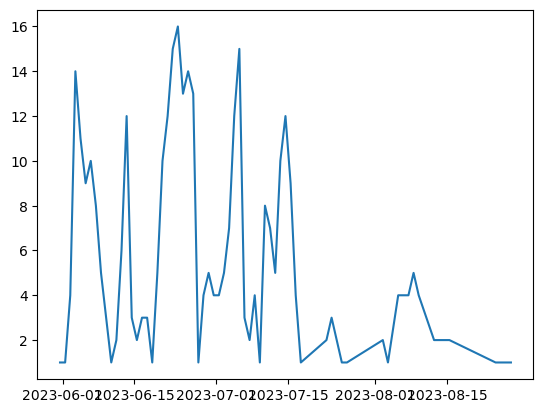

In [62]:
plt.plot(num_fires.t, num_fires.iloc[:, 1:])

pretty_date_format,05-30,05-31,06-01,06-02,06-03,06-04,06-05,06-06,06-07,06-08,...,08-25,08-26,08-27,08-28,08-29,08-30,08-31,09-01,09-02,09-03
58.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47.12,NaN,NaN,NaN,NaN,NaN,6.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47.00,NaN,NaN,NaN,NaN,3.0,3.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46.94,NaN,NaN,NaN,NaN,3.0,3.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
sum_growth = grow_day[grow_day.farea_diff >= 0].groupby("t").farea_diff.sum().reset_index()
#ig_growth = grow_day[grow_day.farea_diff.isna()].groupby("t").farea.rest_index()

grow_day

,index,fireID,pretty_date_format,farea_diff,log_difference,t,FWI,lat_centroid,farea_diff_mod
0,1,10013,06-13,10.0,2.302585,2023-06-13 12:00:00,7.438308,52.516399,11.0
1,3,10056,06-13,7.0,1.945910,2023-06-13 12:00:00,3.789797,51.141514,8.0
2,4,10056,06-14,8.0,2.079442,2023-06-14 12:00:00,5.039475,51.141514,9.0
3,5,10056,06-15,7.0,1.945910,2023-06-15 12:00:00,0.011286,51.141514,8.0
4,6,10056,06-16,0.0,-inf,2023-06-16 12:00:00,0.010081,51.141514,1.0
...,...,...,...,...,...,...,...,...,...
1559,3619,9843,07-04,112.0,4.718499,2023-07-04 12:00:00,7.361705,54.005703,113.0
1560,3620,9843,07-05,45.0,3.806662,2023-07-05 12:00:00,10.175493,54.005703,46.0
1561,3621,9843,07-06,0.0,-inf,2023-07-06 12:00:00,0.032171,54.005703,1.0
1562,3622,9843,07-07,0.0,-inf,2023-07-07 12:00:00,0.158238,54.005703,1.0


In [ ]:
with mpl.rc_context({'font.size': 14}):
    fig1, ([ax, ax2], [ax3, ax4], [ax5, ax6], [ax7, ax8], [ax9, ax10]) = plt.subplots(5,2, gridspec_kw={'width_ratios':[100,4], 'height_ratios': [2,2, 10, 3, 3]}, constrained_layout=True)#constrained_layout=True
    #fig.suptitle('Aligning x-axis using sharex')

    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    ax.plot(fwin.INITDATE.astype("datetime64[ns]"),fwin.GEOS_5)
    ax.set_xlim(test_func[1].t.astype("datetime64[ns]").min(), test_func[1].t.astype("datetime64[ns]").max())
    ax.set_ylabel("North")
    #ax.set_xticklabels("")
    ax.axes.get_xaxis().set_visible(False)
    #ax.set_yticklabels("")


    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%-d'))
    ax3.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
    ax3.set_xlim(test_func[1].t.astype("datetime64[ns]").min(), test_func[1].t.astype("datetime64[ns]").max())
    ax3.set_ylabel("South")
    #ax3.set_yticklabels("")



    #ax3 = 
    #sn.heatmap(heat, cmap = "YlOrBr", norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, ax = ax5, cbar_ax=ax6, square=False)#,fmt='.1f', 
    sn.heatmap(test_func[0], cmap = darker_cmap, norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, ax = ax5, cbar_ax=ax6, square=False)#,fmt='.1f', 
    ax5.set(xlabel="", ylabel="Latitude of Fire Event")
    ax5.axes.get_xaxis().set_visible(False)
    ax5.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(quick_round2))
    #ax5.set_xticklabels("")
    #ax5.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    #ax7.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%-d'))
    ax7.axes.get_xaxis().set_visible(False)
    ax7.plot(num_fires.t, num_fires.iloc[:, 1:])
    ax7.set_ylabel("") # # >= 20
    
    ax9.axes.get_xaxis().set_visible(False)
    ax9.plot(sum_growth.t, sum_growth.iloc[:, 1:])
    ax9.set_ylabel("") # Total km
   
    ax2.remove()
    ax4.remove()
    ax8.remove()
    ax10.remove()
    
    plt.savefig('/projects/old_shared/fire_weather_vis/Lightning_analysis/some_figs/Number_of_fires_growing_over_20km2_Regional_fire_growth_FWI.png', dpi = 900, transparent = False)

In [ ]:
fig2, ([ax2, ax3]) = plt.subplots(1,2, figsize = (12.5, 6.25), gridspec_kw={'width_ratios': [2,2], 'height_ratios': [1]}, constrained_layout=True)
#fig.suptitle('Aligning x-axis using sharex')
sn.heatmap(get_fwi[0], cmap = "cool", cbar_kws={'label': 'Fire Weather Index'}, ax = ax2, fmt='.1f', square = False)#, 
               #yticklabels=heat.index.values.round(0))
ax2.set(xlabel="", ylabel="Latitude of Fire Event")
ax2.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(quick_round2))

sn.heatmap(test_func[0], cmap = darker_cmap, norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, ax = ax3, square = False)#,fmt='.1f', 
ax3.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(quick_round2))
ax3.set(xlabel="", ylabel="")
#ax3.axes.get_xaxis().set_visible(False)


#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
#ax.set_xlim(get_fwi[1].t.astype("datetime64[ns]").min(), get_fwi[1].t.astype("datetime64[ns]").max())
#ax.set_ylabel("FWI")

#plt.savefig('FWI_for_darker_Regional_fire_growth_FWI.png', dpi = 900, transparent = True)

plt.savefig('/projects/old_shared/fire_weather_vis/Lightning_analysis/some_figs/Both_FWI_for_darker_Regional_fire_growth_FWI.png', dpi = 900, transparent = False)

In [ ]:
with mpl.rc_context({'font.size': 14}):
    fig1, ([ax5, ax6], [ax7, ax8], [ax9, ax10]) = plt.subplots(3,2, gridspec_kw={'width_ratios':[100,4], 'height_ratios': [20, 7, 7]}, constrained_layout=True)#constrained_layout=True
    #fig.suptitle('Aligning x-axis using sharex')

    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

#     ax.plot(fwin.INITDATE.astype("datetime64[ns]"),fwin.GEOS_5)
#     ax.set_xlim(get_fwi[0].t.astype("datetime64[ns]").min(), test_func[1].t.astype("datetime64[ns]").max())
#     ax.set_ylabel("North")
#     #ax.set_xticklabels("")
#     ax.axes.get_xaxis().set_visible(False)
#     #ax.set_yticklabels("")


#     ax3.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%-d'))
#     ax3.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
#     ax3.set_xlim(get_fwi[0].t.astype("datetime64[ns]").min(), test_func[1].t.astype("datetime64[ns]").max())
#     ax3.set_ylabel("South")
#     #ax3.set_yticklabels("")



    #ax3 = 
    #sn.heatmap(heat, cmap = "YlOrBr", norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, ax = ax5, cbar_ax=ax6, square=False)#,fmt='.1f', 
    sn.heatmap(get_fwi[0], cmap = "cool", cbar_kws={'label': 'Fire Weather Index'}, ax = ax5, cbar_ax=ax6, square=False)#,fmt='.1f', 
    ax5.set(xlabel="", ylabel="Latitude of Fire Event")
    ax5.axes.get_xaxis().set_visible(False)
    ax5.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(quick_round2))
    #ax5.set_xticklabels("")
    #ax5.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    #ax7.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%-d'))
    ax7.axes.get_xaxis().set_visible(False)
    ax7.plot(num_fires.t, num_fires.iloc[:, 1:])
    #ax7.set_ylabel("# > 20") # # >= 20
    ax7.set_title("# Fires >= 20km^2 Growth")
    
    #ax9.axes.get_xaxis().set_visible(False)
    ax9.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%-d'))
    ax9.plot(sum_growth.t, sum_growth.iloc[:, 1:])
    ax9.set_title("Total Area Growth km^2")
    #ax9.set_ylabel("Sum Growth", rotation=0) # Total km
   
    #ax2.remove()
    #ax4.remove()
    ax8.remove()
    ax10.remove()
    
    plt.savefig('/projects/old_shared/fire_weather_vis/Lightning_analysis/some_figs/Number_of_fires_growing_over_20km2_Regional_FWI.png', dpi = 900, transparent = False)
    
    
    

# Interactive plotly plot for writing up the results

In [ ]:
with mpl.rc_context({'font.size': 14}):
    fig1, ([ax, ax2], [ax3, ax4], [ax5, ax6], [ax7, ax8], [ax9, ax10]) = plt.subplots(5,2, gridspec_kw={'width_ratios':[100,4], 'height_ratios': [2,2, 10, 3, 3]}, constrained_layout=True)#constrained_layout=True
    #fig.suptitle('Aligning x-axis using sharex')

    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    ax.plot(fwin.INITDATE.astype("datetime64[ns]"),fwin.GEOS_5)
    ax.set_xlim(test_func[1].t.astype("datetime64[ns]").min(), test_func[1].t.astype("datetime64[ns]").max())
    ax.set_ylabel("North")
    #ax.set_xticklabels("")
    ax.axes.get_xaxis().set_visible(False)
    #ax.set_yticklabels("")


    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%-d'))
    ax3.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
    ax3.set_xlim(test_func[1].t.astype("datetime64[ns]").min(), test_func[1].t.astype("datetime64[ns]").max())
    ax3.set_ylabel("South")
    #ax3.set_yticklabels("")



    #ax3 = 
    #sn.heatmap(heat, cmap = "YlOrBr", norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, ax = ax5, cbar_ax=ax6, square=False)#,fmt='.1f', 
    sn.heatmap(test_func[0], cmap = darker_cmap, norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, ax = ax5, cbar_ax=ax6, square=False)#,fmt='.1f', 
    ax5.set(xlabel="", ylabel="Latitude of Fire Event")
    ax5.axes.get_xaxis().set_visible(False)
    ax5.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(quick_round2))
    #ax5.set_xticklabels("")
    #ax5.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    #ax7.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%-d'))
    ax7.axes.get_xaxis().set_visible(False)
    ax7.plot(num_fires.t, num_fires.iloc[:, 1:])
    ax7.set_ylabel("") # # >= 20
    
    ax9.axes.get_xaxis().set_visible(False)
    ax9.plot(sum_growth.t, sum_growth.iloc[:, 1:])
    ax9.set_ylabel("") # Total km
   
    ax2.remove()
    ax4.remove()
    ax8.remove()
    ax10.remove()
    
    #plt.savefig('/projects/old_shared/fire_weather_vis/Lightning_analysis/some_figs/Number_of_fires_growing_over_20km2_Regional_fire_growth_FWI.png', dpi = 900, transparent = False)

### Look at % of total area by extreme weather

In [ ]:
## Double check how extensive merge assumptions are
fires = fires.sort_values(by = "t")
fires["farea_diff"] = fires[row_mask].groupby("fireID").farea.diff()
final_area = fires[fires.farea_diff >= 0].groupby("fireID").farea_diff.sum().reset_index()
#diff = fires[fires["farea_diff"] >= 0].groupby("fireID").farea_diff.sum().reset_index()
#joined = final_area.merge(diff, on = "fireID")

#ids_with_invalid_merge_assumptions = joined[joined.farea <= joined.farea_diff].fireID.unique()

#print(f' Total number of fires {len(joined.fireID.unique())},  total number of fires with merge assumptions: {len(joined[joined.farea <= joined.farea_diff].fireID.unique())}')
#print(ids_with_invalid_merge_assumptions)

#row_mask = ~fires.fireID.isin(ids_with_invalid_merge_assumptions)
#ids_with_invalid_merge_assumptions

In [ ]:
# print(fires[row_mask].groupby("fireID").farea.max().reset_index().farea.sum())
# print(fires[row_mask].groupby("fireID").farea_diff.sum().reset_index().farea_diff.sum())



# ####
# print(len(fires[row_mask]))

# len(fires[row_mask & (fires.farea_diff >= 0)])

difference_area.farea_diff

In [ ]:
fwi_thresh = 7
fwi_var = "FWI"

def get_area_fire(fires):
    fires = fires.sort_values(by = "t")
    fires["farea_diff"] = fires.groupby("fireID").farea.diff()
    
    ignition_area = fires[fires.farea_diff.isna()].groupby("fireID").farea.sum().reset_index() ## Represents the first observation per fire
    ignition_area = ignition_area.rename(columns = {"farea":"ig"})

    merge_ignition_area = fires[fires.farea_diff < 0].groupby("fireID").farea.sum().reset_index() ## Represents the moment that new fire was merged into the id -- secondary ignition
    merge_ignition_area = merge_ignition_area.rename(columns = {"farea":"merge_ig"})

    difference_area = fires[fires.farea_diff >= 0].groupby("fireID").farea_diff.sum().reset_index()
    difference_area=difference_area.rename(columns = {"farea_diff":"diff_area"})

    final_area = ignition_area.merge(merge_ignition_area, on = "fireID", how = "outer")
    final_area = final_area.merge(difference_area, on = "fireID", how = "outer")
    
    final_area.loc[final_area.ig.isna(),['ig']] = 0
    final_area.loc[final_area.merge_ig.isna(), ["merge_ig"]] = 0
    final_area.loc[final_area.diff_area.isna(), ["diff_area"]] = 0
    
    final_area["farea_tot"] = final_area.ig + final_area.merge_ig + final_area.diff_area
    

    return(final_area)
final_area = get_area_fire(fires)

high_fwi = get_area_fire(fires[fires[fwi_var] >= fwi_thresh])

per_fire = final_area.merge(high_fwi, on = "fireID",  how = "outer", suffixes = [None, "_fwi"]) ## x is high_fwi


for n in final_area.columns[1:]:
    per_fire[n+"_pct"] = per_fire[n + "_fwi"] /per_fire[n]

per_fire.loc[per_fire.farea_tot_pct.isna(),["farea_tot_pct"]] = 0
#### print useful statements

print(f'There were a total of {len(final_area.fireID.unique())} fires, for a total of {final_area.farea_tot.sum().round()} km^2. ')

print(f"Of that total, {np.round((high_fwi.farea_tot.sum() / final_area.farea_tot.sum()) * 100)} percent of the area was when {fwi_var} was >= than {fwi_thresh}")

print(f"Per fire, on average {per_fire.farea_tot_pct.mean()}of the area came from when {fwi_var} was >= than {fwi_thresh}, or a median of {np.round(per_fire.farea_tot_pct.median(), 2)}, with 0.025 being {per_fire.farea_tot_pct.quantile(0.025)} and 0.975 being {per_fire.farea_tot_pct.quantile(0.975)} ")






In [ ]:
#per_fire

In [ ]:
# final_area["farea"] = ignition_area.farea +difference_area.farea_diff + merge_ignition_area.farea

# total_area = final_area.farea.sum()

# #fires = fires.sort_values(by = "t")
# #fires["farea_diff"] = fires[row_mask].groupby("fireID").farea.diff()

# area_during_high_fwi_ig = fires[(fires[fwi_var] >= fwi_thresh) & fires.farea_diff.isna()].groupby("fireID").farea_diff.sum().reset_index()
# area_during_high_fwi_diff = fires[(fires[fwi_var] >= fwi_thresh)].groupby("fireID").farea_diff.sum().reset_index() # (fires[fwi_var] >= fwi_thresh) & (fires["farea_diff"] >= 0)
# area_during_high_fwi_diff = fires[(fires[fwi_var] >= fwi_thresh) & (fires.farea_diff < 0) ].groupby("fireID").farea_diff.sum().reset_index()



# tot_area_during_high_fwi = area_during_high_fwi.farea_diff.sum()

# print(f' Of a total area of {total_area} km^2, {tot_area_during_high_fwi} was during {fwi_var} > {fwi_thresh}, or {(tot_area_during_high_fwi/total_area) * 100} percent of the area')

In [ ]:
# ### On a per-fire basis

# merged = final_area.merge(area_during_high_fwi, on = "fireID")

# num_fires = len(merged.fireID.unique())

# merged = merged[merged.farea >= merged.farea_diff]

# num_fires_weird_area = num_fires - len(merged.fireID.unique())

# print(f'{num_fires_weird_area} may be affected by merge assumptions out of {num_fires} total. ')

# merged["percent_high_fwi"] = merged.farea_diff/merged.farea  ## Actually not very high percentage -- Would we need to do temporal smoothing??? 

# print(f'Out of { num_fires - len(merged.fireID.unique())}, on average a given fire would have {merged["percent_high_fwi"].mean()} fractinoal area during  {fwi_var} > {fwi_thresh}') ## Actually not very high percentage, seems like more zeros than expected -- Would we need to do temporal smoothing??? It seems like some fire differences area "missing" 

In [ ]:
# fires = fires.sort_values(by = "t")

# fwi_thresh = 7
# fwi_var = "GEOS-5.IMERGEARLY"

# final_area = fires.groupby("fireID").farea.max().reset_index()
# total_area = final_area.farea.sum()


# area_during_high_fwi = fires[(fires[fwi_var] >= fwi_thresh) & (fires["farea_diff"] >= 0)].groupby("fireID").farea_diff.sum().reset_index()

# tot_area_during_high_fwi = area_during_high_fwi.farea_diff.sum()

# print(f' Of a total area of {total_area} km^2, {tot_area_during_high_fwi} was during {fwi_var} > {fwi_thresh}, or {(tot_area_during_high_fwi/total_area) * 100} percent of the area')



# ### On a per-fire basis

# merged = final_area.merge(area_during_high_fwi, on = "fireID")

# num_fires = len(merged.fireID.unique())

# merged = merged[merged.farea >= merged.farea_diff]

# num_fires_weird_area = num_fires - len(merged.fireID.unique())

# print(f'{num_fires_weird_area} may be affected by merge assumptions out of {num_fires} total. ')

# merged["percent_high_fwi"] = merged.farea_diff/merged.farea  ## Actually not very high percentage -- Would we need to do temporal smoothing??? 

# print(f'Out of { num_fires - len(merged.fireID.unique())}, on average a given fire would have {merged["percent_high_fwi"].mean()} fractinoal area during  {fwi_var} > {fwi_thresh}') ## Actually not very high percentage, seems like more zeros than expected -- Would we need to do temporal smoothing??? It seems like some fire differences area "missing" 

In [ ]:
#fires.columns

In [ ]:
# fires.loc[(fires.fireID == '10718') & (fires.t > "2023-06-04 12:00:00"), ['fireID', 't',  'n_newpixels', 'farea', 'fperim',
#        'flinelen', 'duration', 'pixden', 'meanFRP', 'GEOS-5.IMERGEARLY', 'FWI',
#         'composit_ids','farea_diff']]

In [ ]:
fires["meta_id"] = fires.fireID.astype("str") + fires.composit_ids.astype("str")

In [ ]:
fires

In [ ]:
# print(fires[(fires.fireID == fires.composit_ids)].groupby("fireID").farea.max().reset_index().farea.sum())
# print(fires[(fires.fireID == fires.composit_ids) & (fires.farea_diff >= 0)].groupby("fireID").farea_diff.sum().reset_index().farea_diff.sum())

In [ ]:
#fires.groupby("meta_id").farea.max()

In [ ]:

# short_fires = fires.groupby("fireID").duration.max().reset_index()
# sf = short_fires[short_fires.duration <= 4].fireID.unique()
# print(sf)
# #fires[fires.]

In [ ]:
# fires.loc[fires.fireID =='12144', ['fireID', 't',  'n_newpixels', 'farea', 'fperim',
#        'flinelen', 'duration', 'pixden', 'meanFRP', 'GEOS-5.IMERGEARLY', 'FWI',
#         'composit_ids','farea_diff']]

In [ ]:
# print(fires.loc[fires.fireID =='8928', ['fireID', 't',  'n_newpixels', 'farea', 'fperim',
#        'flinelen', 'duration', 'pixden', 'meanFRP', 'GEOS-5.IMERGEARLY', 'FWI',
#         'composit_ids','farea_diff']].farea_diff.sum())

# fires.loc[fires.fireID =='8928', ['fireID', 't',  'n_newpixels', 'farea', 'fperim',
#        'flinelen', 'duration', 'pixden', 'meanFRP', 'GEOS-5.IMERGEARLY', 'FWI',
#         'composit_ids','farea_diff']].farea.max()


# print(fires.loc[fires.fireID =='8928', ['fireID', 't',  'n_newpixels', 'farea', 'fperim',
#        'flinelen', 'duration', 'pixden', 'meanFRP', 'GEOS-5.IMERGEARLY', 'FWI',
#         'composit_ids','farea_diff']].farea.max() - fires.loc[fires.fireID =='8928', ['fireID', 't',  'n_newpixels', 'farea', 'fperim',
#        'flinelen', 'duration', 'pixden', 'meanFRP', 'GEOS-5.IMERGEARLY', 'FWI',
#         'composit_ids','farea_diff']].farea_diff.sum())

In [ ]:
?fires.farea.diff